In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [280]:
df = pd.read_csv('./Social_Network_Ads.csv.xls')

In [281]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [282]:
df.isna().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [283]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}\n")

User ID: [15624510 15810944 15668575 15603246 15804002 15728773 15598044 15694829
 15600575 15727311 15570769 15606274 15746139 15704987 15628972 15697686
 15733883 15617482 15704583 15621083 15649487 15736760 15714658 15599081
 15705113 15631159 15792818 15633531 15744529 15669656 15581198 15729054
 15573452 15776733 15724858 15713144 15690188 15689425 15671766 15782806
 15764419 15591915 15772798 15792008 15715541 15639277 15798850 15776348
 15727696 15793813 15694395 15764195 15744919 15671655 15654901 15649136
 15775562 15807481 15642885 15789109 15814004 15673619 15595135 15583681
 15605000 15718071 15679760 15654574 15577178 15595324 15756932 15726358
 15595228 15782530 15592877 15651983 15746737 15774179 15667265 15655123
 15595917 15668385 15709476 15711218 15798659 15663939 15694946 15631912
 15768816 15682268 15684801 15636428 15809823 15699284 15786993 15709441
 15710257 15582492 15575694 15756820 15766289 15593014 15584545 15675949
 15672091 15801658 15706185 15789863 15720

#### First thing we got to do is drop the User ID column, because it will not be usefull for us in any way.

In [284]:
df = df.drop(['User ID'],axis=1)

In [285]:
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


### Exploratory Analysis

1. Lets see the distribution of each column, we can see more of this information with the **.describe** method.


In [286]:
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


#### Well although we can see usefull information from the describe method, it is not easy to see anything, lets try to plot a histogram with the data

2. To plot a histogram to see the distribution of the data we can use the **.plt.hist(data)**

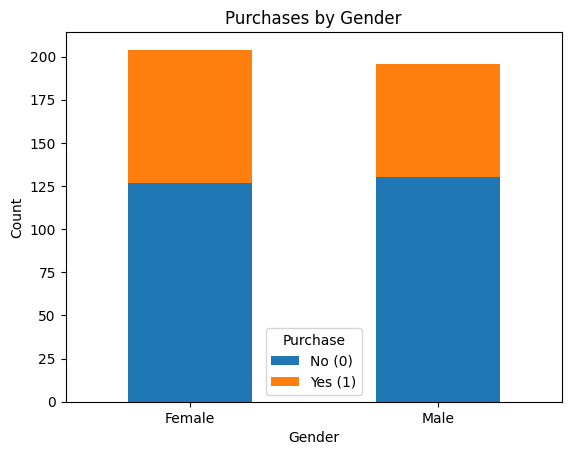

In [287]:
grouped_data = df.groupby(['Gender', 'Purchased']).size().unstack(fill_value=0)

# Plot the histogram
grouped_data.plot(kind='bar', stacked=True)
plt.title('Purchases by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Purchase', labels=['No (0)', 'Yes (1)'])
plt.show()

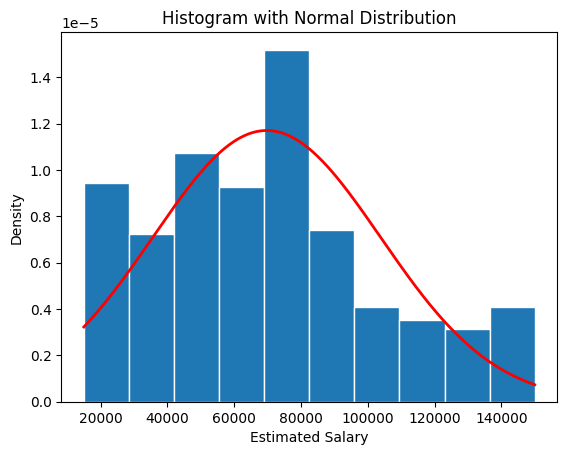

In [288]:
from scipy.stats import norm

# Plot the histogram
plt.hist(df['EstimatedSalary'], bins=10, density=True, alpha=1.0, edgecolor='white')

# Calculate the mean and standard deviation
mean = df['EstimatedSalary'].mean()
std = df['EstimatedSalary'].std()

# Generate a range of values for the normal distribution
x = np.linspace(df['EstimatedSalary'].min(), df['EstimatedSalary'].max(), 1000)
pdf = norm.pdf(x, mean, std)

# Plot the normal distribution
plt.plot(x, pdf, 'r', linewidth=2)
plt.title('Histogram with Normal Distribution')
plt.xlabel('Estimated Salary')
plt.ylabel('Density')
plt.show()

### Lets treat our data

#### For that we have to remember that not only models normally dont accept categorical values, but it is also required it to be in numerical values for both the model and for correlation matrix because its heatmap require numerical values for the correlation coefficient (e.g., Pearson correlation) which is a numerical measure of the linear relationship between two variables.

1. So first lets see our data types in our dataset.
2. Then we have to convert the categorical types to int/float

In [289]:
#1
df.dtypes

Gender             object
Age                 int64
EstimatedSalary     int64
Purchased           int64
dtype: object

In [290]:
#2
#Right our only categorical data is the Gender column as a type object, lets transform it with Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer

# Function to transform Gender column
def label_encode_gender(df):
    encoder = LabelEncoder()
    df['Gender'] = encoder.fit_transform(df['Gender'])
    return df

# Create a pipeline with a custom transformer
pipeline = Pipeline([
    ('gender_label_encoding', FunctionTransformer(label_encode_gender))
])

# Transform the data
df_transformed = pipeline.fit_transform(df)
print(df_transformed)

     Gender  Age  EstimatedSalary  Purchased
0         1   19            19000          0
1         1   35            20000          0
2         0   26            43000          0
3         0   27            57000          0
4         1   19            76000          0
..      ...  ...              ...        ...
395       0   46            41000          1
396       1   51            23000          1
397       0   50            20000          1
398       1   36            33000          0
399       0   49            36000          1

[400 rows x 4 columns]


#### Well for the Logistic Regression model we have it all right

1. The data is all numerical
2. The data is properly cleaned
3. The data doesn`t contain null values or missing values

#### So lets start developing our model

1. Separate the X values and Y value that is the target (Purchased)
2. Use the **train_test_split** to properly separate our data on training and test.
3. Fit the model **Logistic Regression**, with the training data.
4. At last see our model scoring

In [291]:
#1
X = df.drop(columns = ['Purchased'], axis=1)
y = df['Purchased']

In [292]:
X.head()

,Gender,Age,EstimatedSalary
0,1,19,19000
1,1,35,20000
2,0,26,43000
3,0,27,57000
4,1,19,76000


In [293]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Purchased, dtype: int64

In [294]:
#2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42) 

In [295]:
#3
model = LogisticRegression(solver = 'liblinear', random_state = 42) #liblinear is good for small datasets
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [296]:
#4
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.66      1.00      0.79        52
           1       1.00      0.04      0.07        28

    accuracy                           0.66        80
   macro avg       0.83      0.52      0.43        80
weighted avg       0.78      0.66      0.54        80



#### We have a huge problem here, the recall score for the 1 label is pretty bad
##### The recall score of the label 1 tells us that the model only identified 4% of the true instances of class 1. But that can be fixed right? Well we can try.    

##### For better undertanding, this miss classification is normally caused by disproportional datasets, where one class have much more data then the other. 

1. First lets check the Purchased data to see its proportion



In [297]:
#1
df.Purchased.value_counts(1)

Purchased
0    0.6425
1    0.3575
Name: proportion, dtype: float64

Well that could have been worst, we have 64% of class 0 present in the data and 35% od class 1.
Lets try to bring that to a 50/50 proportion with a technic called **SMOTE**, that creates data for the class that has less data.

In [298]:
X = df.drop(columns = ['Purchased'], axis=1)
y = df['Purchased']

In [299]:
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [300]:
from collections import Counter
print("Class distribution before resampling:", Counter(y_train))
print("Class distribution after resampling:", Counter(y_train_res))

Class distribution before resampling: Counter({0: 205, 1: 115})
Class distribution after resampling: Counter({0: 205, 1: 205})


#### After applying SMOTE we got a 50/50 proportion with 205 to class 0 and 205 to class 1, but thats not all, we have a problem with our data, that is not the proportion, lets take a look at the distribution of the data in the Ages column and the EstimatedSalary.

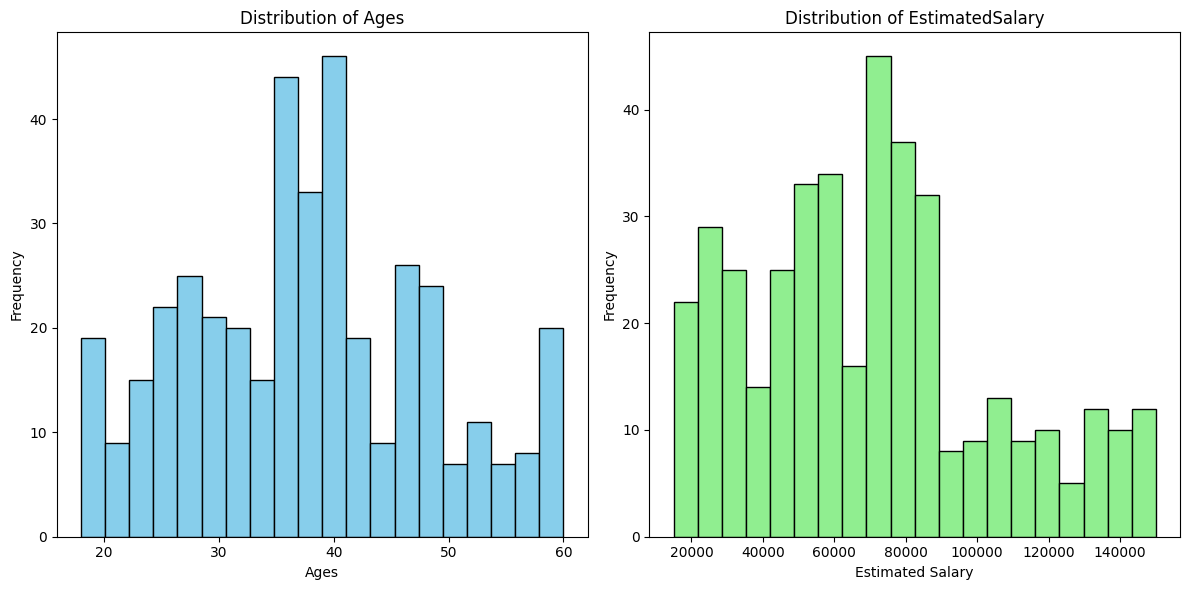

In [307]:
plt.figure(figsize=(12, 6))

# Plot distribution of 'ages'
plt.subplot(1, 2, 1)
plt.hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ages')
plt.xlabel('Ages')
plt.ylabel('Frequency')

# Plot distribution of 'EstimatedSalary'
plt.subplot(1, 2, 2)
plt.hist(df['EstimatedSalary'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of EstimatedSalary')
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [301]:
from sklearn.preprocessing import StandardScaler
# Define numeric and categorical columns
numeric_features = ['Age', 'EstimatedSalary']
gender_features = ['Gender']

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Apply StandardScaler to numeric features
        ('cat', 'passthrough', gender_features)  # Leave Gender unchanged
    ]
)

# Create a pipeline with preprocessing and Logistic Regression
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(solver = 'liblinear' ,random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

In [302]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        52
           1       0.80      0.86      0.83        28

    accuracy                           0.88        80
   macro avg       0.86      0.87      0.86        80
weighted avg       0.88      0.88      0.88        80

